In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_VPINN import *
from NN_library.train_dual_VPINN import *
from matplotlib.tri import Triangulation
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

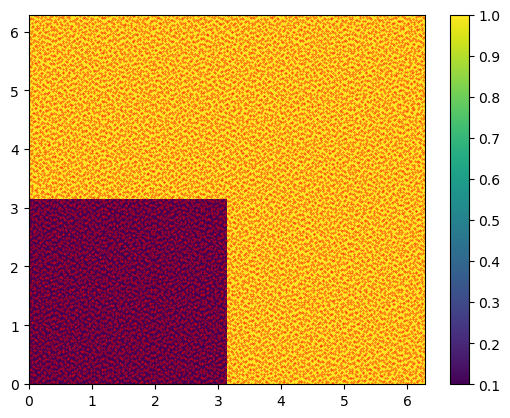

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x<np.pi)&(y<np.pi), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Test functions

## NN-based

In [4]:
N_test = 100
torch.manual_seed(0)
args = {'lr' : 1e-4, 'epochs' : 1000, 'dev' : dev, 'name' : f'NN_library/basis/65_100'}
test_functions = [PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L).to(dev) for i in range(N_test)]
for i in range(N_test):
    test_functions[i] = load_network(test_functions[i], args['name'] + f'_{i}', args)

In [7]:
# compute G if needed
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
x = x.to(dev).requires_grad_(True)

G = torch.zeros((N_test, N_test))
g_test = []
for i in range(N_test):
    y_test = test_functions[i](x)
    grad_test = torch.autograd.grad(
                outputs=y_test, inputs=x,
                grad_outputs=torch.ones_like(y_test)
            )[0]
    g_test.append(grad_test.detach())

for i in range(N_test):
    for j in range(i, N_test):
        intgr = compute_int(areas, tri, g_test[i], g_test[j])
        G[i,j] = intgr
        G[j,i] = intgr

#torch.save(G, "G_primal_65.pt")
G_inv = torch.linalg.inv(G).to(dev)

In [5]:
G = torch.load("G_primal_65.pt")[:N_test,:N_test]
G_inv = torch.linalg.inv(G).to(dev)

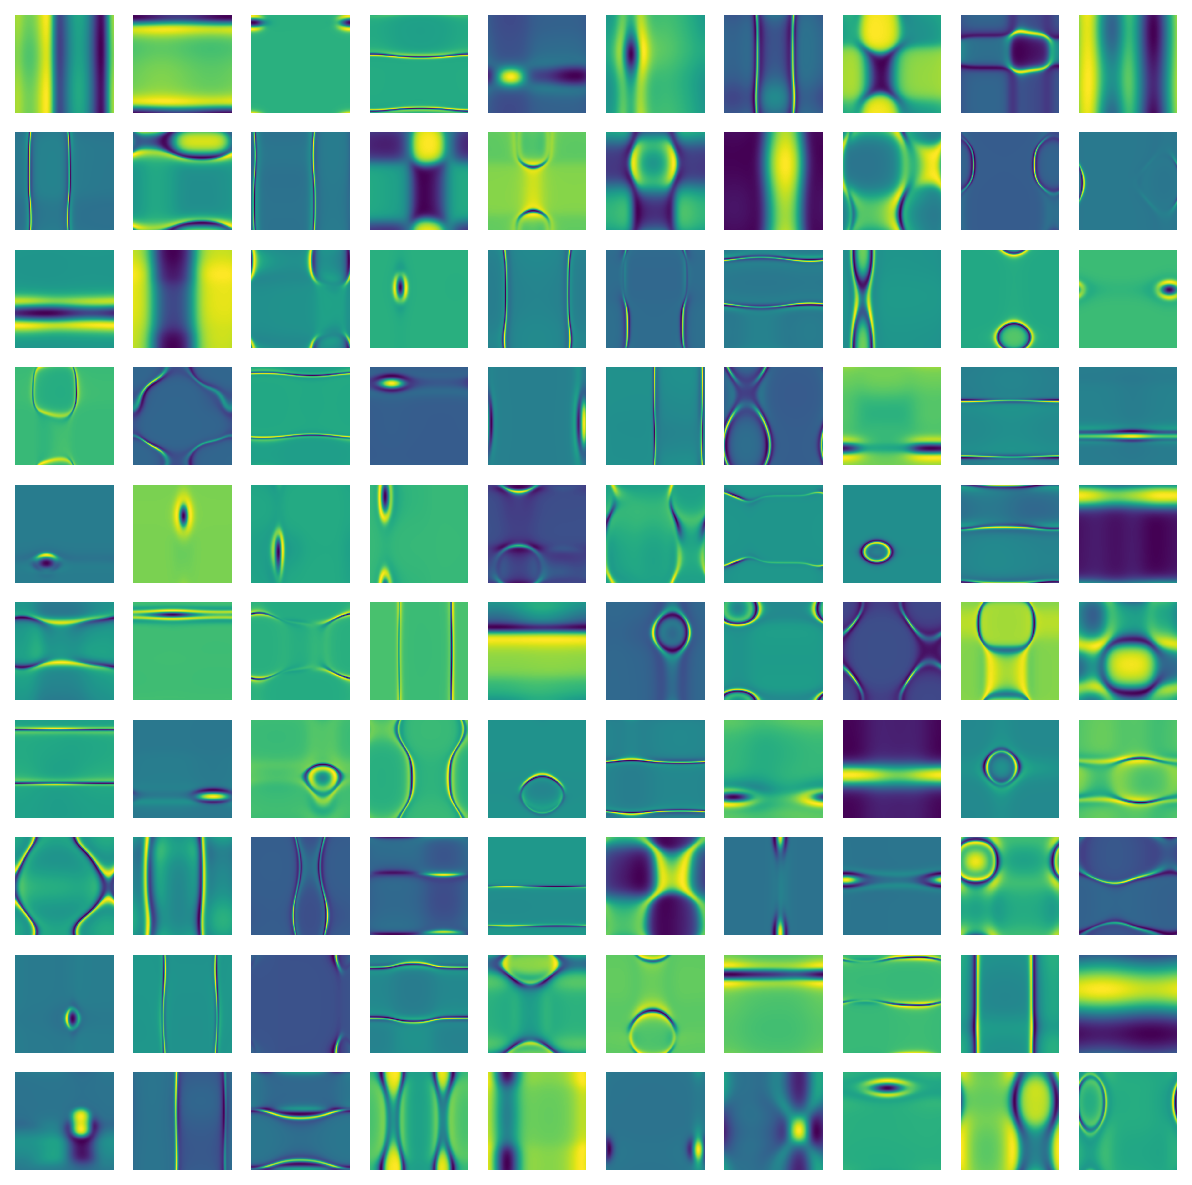

In [8]:
fig, axs = plt.subplots(nrows=10, ncols=N_test//10, figsize=(N_test//10,10), dpi=150)
for i in range(len(test_functions)):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach())
    axs.flat[i].set_axis_off()

# Primal PINN

In [10]:
net_primal = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 1e-4, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_primal_ort_{total_params}_{N_test}'}

Number of parameters: 65


In [ ]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [11]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  2.47815752e+00, mean val. loss:  7.80787170e-01
Epoch: 1 mean train loss:  2.47458911e+00, mean val. loss:  7.80752778e-01
Epoch: 2 mean train loss:  2.47103167e+00, mean val. loss:  7.80718565e-01
Epoch: 3 mean train loss:  2.46748662e+00, mean val. loss:  7.80684471e-01
Epoch: 4 mean train loss:  2.46395230e+00, mean val. loss:  7.80650437e-01
Epoch: 5 mean train loss:  2.46043015e+00, mean val. loss:  7.80616581e-01
Epoch: 6 mean train loss:  2.45691991e+00, mean val. loss:  7.80582786e-01
Epoch: 7 mean train loss:  2.45342159e+00, mean val. loss:  7.80549169e-01
Epoch: 8 mean train loss:  2.44993567e+00, mean val. loss:  7.80515611e-01
Epoch: 9 mean train loss:  2.44646263e+00, mean val. loss:  7.80482173e-01
Epoch: 10 mean train loss:  2.44300127e+00, mean val. loss:  7.80448914e-01
Epoch: 11 mean train loss:  2.43955350e+00, mean val. loss:  7.80415773e-01
Epoch: 12 mean train loss:  2.43611813e+00, mean val. loss:  7.80382693e-01
Epoch: 13 mean train l

In [ ]:
np.save(f'NN_library/training_data/square/VNPINN_primal_ort_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

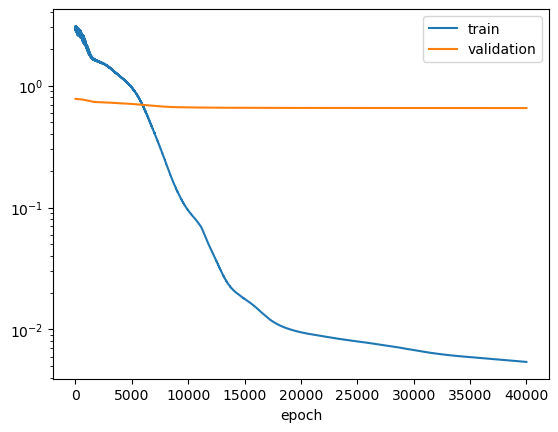

In [13]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [ ]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _ = PDE_loss(grid_data, net_primal, A, H1)

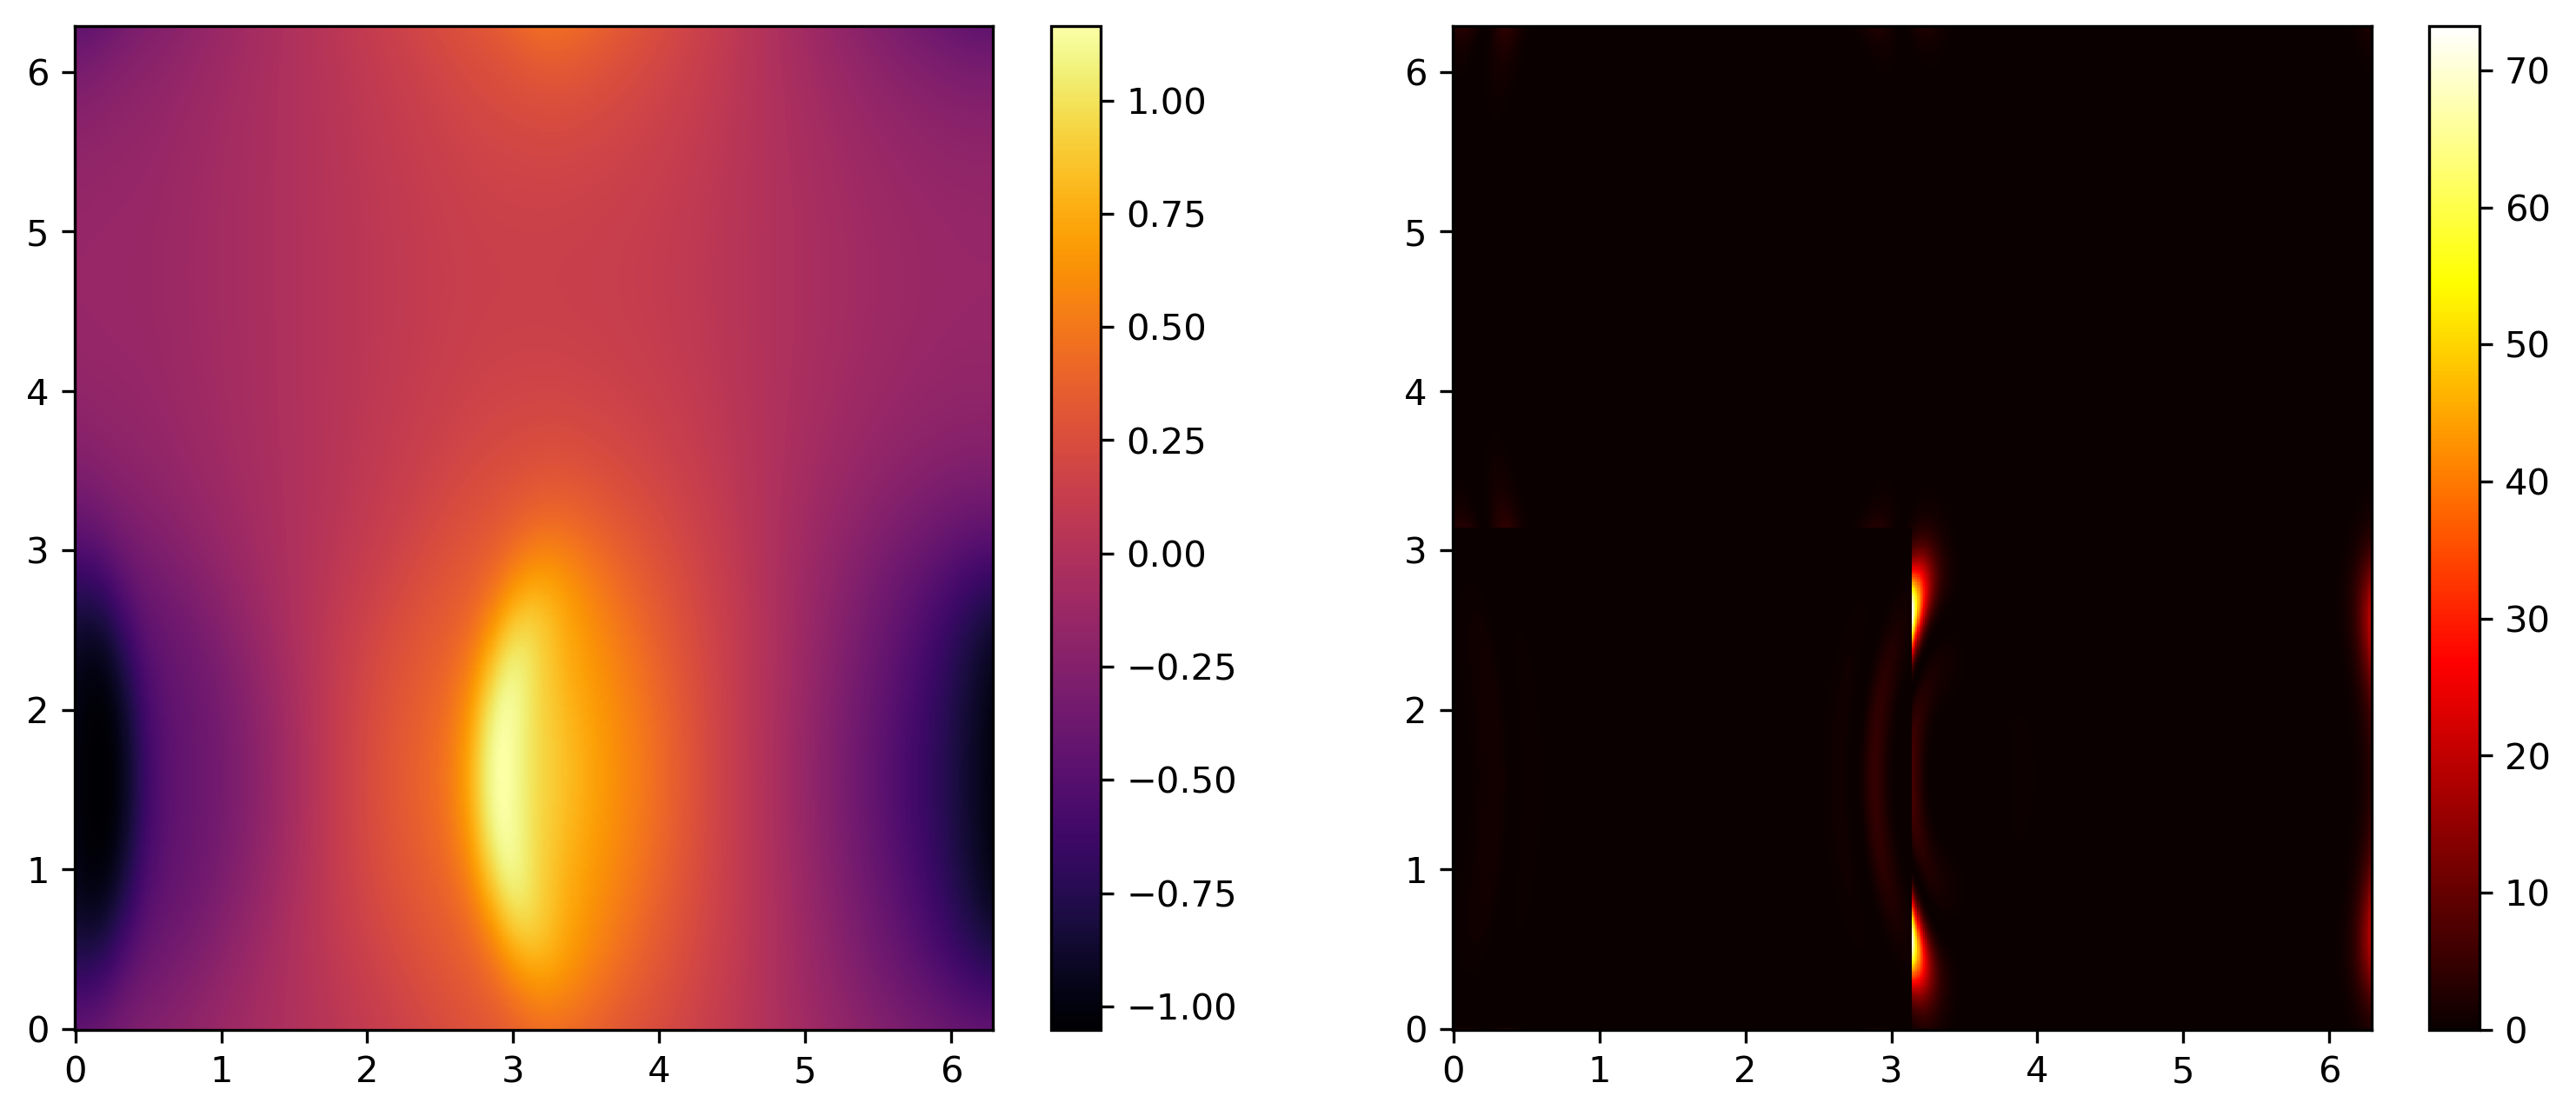

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])

In [ ]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q = PDE_loss(x, net_primal, A, H1)
bound = compute_bound(areas, tri, q, L).detach()[0].item()
print(bound)

np.save(f'bounds/square/A_u_VNPINN_ort_{total_params}_{N_test}.npy', bound)

0.6546745896339417


# Dual PINN

In [19]:
net_dual = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_dual_{total_params}_{N_test}'}

Number of parameters: 65


In [7]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [20]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_inv, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  2.64097229e+02, mean val. loss:  3.07841897e-01
Epoch: 1 mean train loss:  2.66058929e+02, mean val. loss:  3.07843506e-01
Epoch: 2 mean train loss:  2.60778473e+02, mean val. loss:  3.07845056e-01
Epoch: 3 mean train loss:  2.64660950e+02, mean val. loss:  3.07846606e-01
Epoch: 4 mean train loss:  2.61746765e+02, mean val. loss:  3.07848155e-01
Epoch: 5 mean train loss:  2.67976990e+02, mean val. loss:  3.07849735e-01
Epoch: 6 mean train loss:  2.68210083e+02, mean val. loss:  3.07851255e-01
Epoch: 7 mean train loss:  2.62245605e+02, mean val. loss:  3.07852745e-01
Epoch: 8 mean train loss:  2.61678864e+02, mean val. loss:  3.07854265e-01
Epoch: 9 mean train loss:  2.66313934e+02, mean val. loss:  3.07855785e-01
Epoch: 10 mean train loss:  2.69069977e+02, mean val. loss:  3.07857275e-01
Epoch: 11 mean train loss:  2.65194855e+02, mean val. loss:  3.07858765e-01
Epoch: 12 mean train loss:  2.61146606e+02, mean val. loss:  3.07860285e-01
Epoch: 13 mean train l

In [22]:
np.save(f'NN_library/training_data/square/VNPINN_dual_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

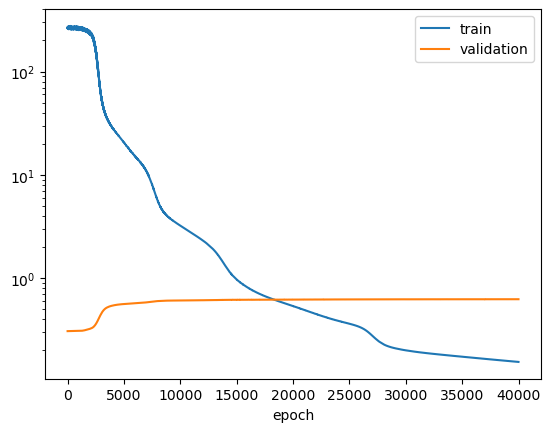

In [21]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [ ]:
U2 = net_dual(grid_data).detach().cpu()
error_2, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

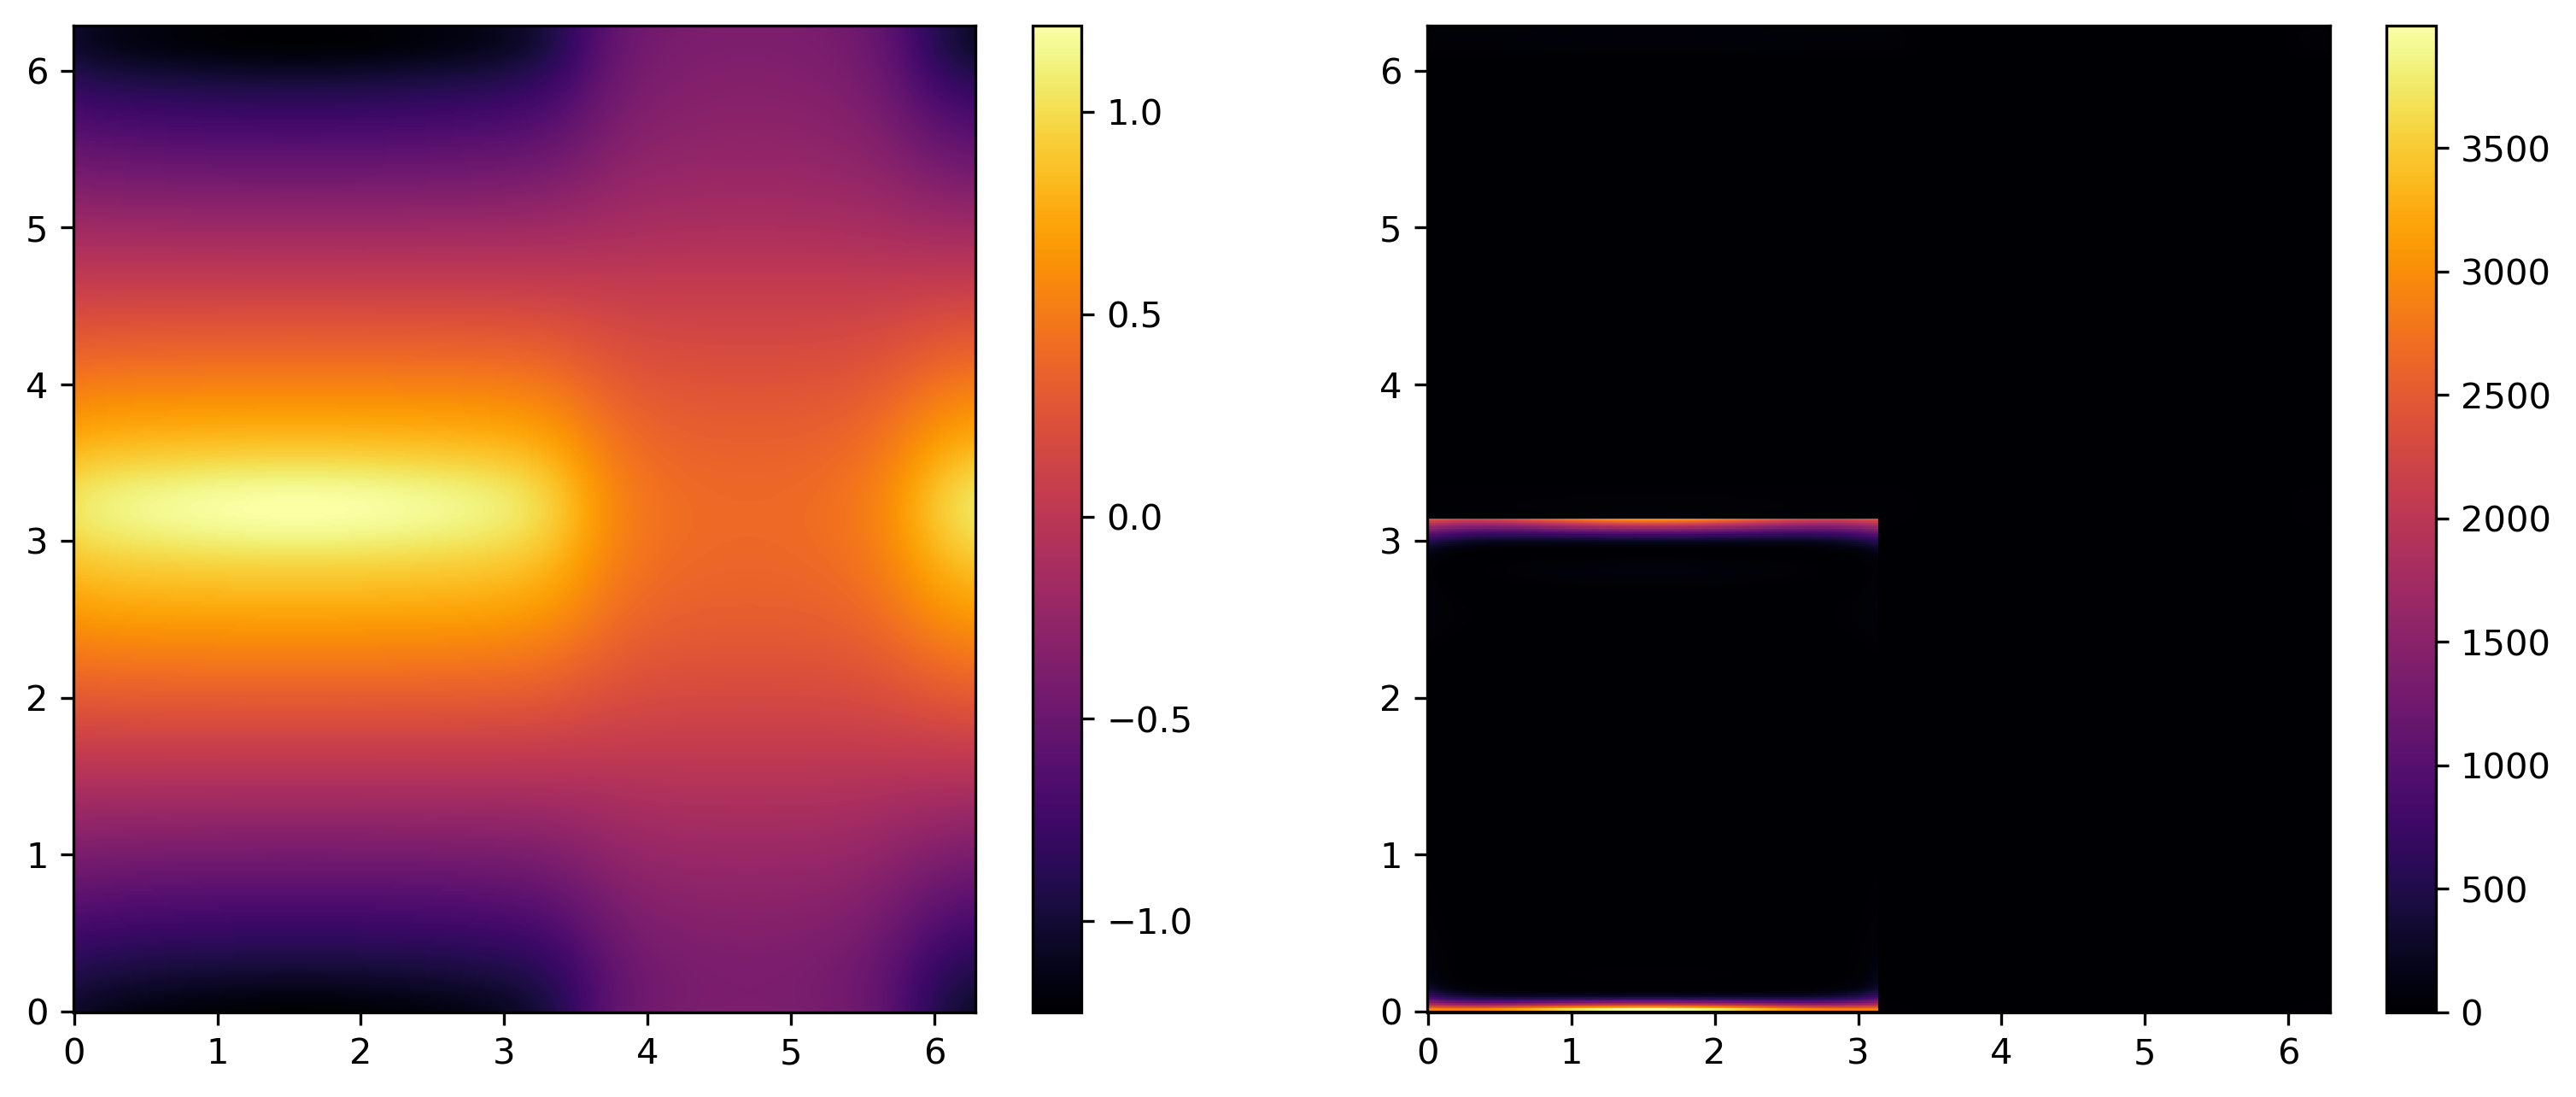

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])

In [32]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q = PDE_loss_dual(x, net_dual, A_inv, H1)
bound = compute_bound(areas, tri, q, L).detach()
bound_inv = bound[0] / (bound[0]**2 - bound[1]**2)
print(bound_inv)

np.save(f'bounds/square/A_l_VNPINN_{total_params}_{N_test}.npy', bound_inv.item())

tensor(0.6268, device='cuda:0')
